In [63]:
## EDA
import sweetviz as sv
my_report = sv.compare(
    [df[df["churn"] == 1].astype(float), "Churn"],
    [df[df["churn"] == 0].astype(float), "Continue"],
    feat_cfg=sv.FeatureConfig(skip="refurb_new"),
)
my_report.show_html("sv_report.html")

                                             |          | [  0%]   00:00 -> (? left)

Report sv_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
from autoviz.AutoViz_Class import AutoViz_Class
av = AutoViz_Class()
autoviz = av.AutoViz(
    filename="", depVar="churn", dfte=df.astype(float), chart_format="html"
)

In [173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import OrdinalEncoder as oe, StandardScaler
ms = StandardScaler()
# lightgbm
import joblib
import lightgbm
import optuna.integration.lightgbm as lgb
from lightgbm import log_evaluation, early_stopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#　カラーパレット設定
color = [ "#68BBE3","#0E86D4", "#003060", "#055C9D", "#D9D9D9", "#FFFFFF", "#5A48AD"]
sns.set_palette(color, 10)

In [174]:
##  データ読み込み
client = pd.read_csv("./client.csv")
record = pd.read_csv("./record.csv")
record["Customer_ID"] = client["Customer_ID"].astype(int)
df = client.merge(record, how="outer", on="Customer_ID")
df.set_index("Customer_ID", inplace=True)
## データ通話はあまり関係なさそうなので削除
df = df[df.columns[~df.columns.str.contains("_dat_")]]
df.drop(columns="ccrndmou_Mean", inplace=True)
df = pd.get_dummies(
    df,
    drop_first=True,
    columns=[
        "new_cell",
        "asl_flag",
        "prizm_social_one",
        "dualband",
        "refurb_new",
        "hnd_webcap",
        "infobase",
        "ownrent",
        "marital",
        "HHstatin",
        "ethnic",
        "creditcd",
        "kid0_2",
        "kid3_5",
        "kid6_10",
        "kid11_15",
        "kid16_17",
    ],
)

## ラベルエンコーディング
for column in df.columns[df.dtypes == "object"]:
    df[column] = oe().fit_transform(df[column].values.reshape(-1, 1))
    df[column] = pd.Series(df[column], dtype=pd.Int64Dtype())

## 欠損値の穴埋め
from sklearn.linear_model import LinearRegression as lr
fill_pred = False
pred_list = []
if fill_pred:
    pred_list = ["adults", "lor", "dwllsize", "hnd_price", "income"]
for column in (
    df.drop(columns=pred_list)
    .isnull()
    .any()
    .index.tolist()
):
    if df[column].dtype == "float64":
        df[column].fillna(df[column].mean(), inplace=True)
    elif df[column].dtype == "Int64":
        df[column].fillna(round(df[column].mean()), inplace=True)
    else:
        df[column].fillna(df[column].mode(), inplace=True)

# 相関関係がある変数で予測
if fill_pred:
    df_pred = df.drop(columns=pred_list)
    for col in pred_list:
        df_pred[col] = df[col].copy()
        feature_num = len(df_pred.columns.tolist()) - 1
        X = ms.fit_transform(
            df_pred.dropna(how="any", subset=[col]).drop(columns=col)
        ).reshape(-1, feature_num)
        y = df_pred.dropna(how="any", subset=[col])[col].values
        lr_fit = lr().fit(X, y)
        df[col] = df_pred.apply(
            lambda x: round(
                lr_fit.predict(
                    ms.fit_transform(
                        np.nan_to_num(x[x.index != col]).reshape(-1, feature_num)
                    )
                )[0]
            )
            if pd.isna(x[col]) or np.isnan(x[col])
            else x[col],
            axis=1,
        ).copy()
        df_pred[col] = df[col].copy()
df.to_csv("./df.csv")

In [ ]:
plt.pie(
    df["churn"].value_counts().values,
    labels=["解約", "継続"],
    autopct="%1.1f%%",
    shadow=True,
    explode=[0.1, 0],
    startangle=90,
)
plt.title("解約する割合")
plt.show()
df["actvsubs"].describe()
f, ax = plt.subplots(3, 2, figsize=(18, 16))
df["churn"].value_counts().plot.pie(
    explode=[0, 0.1], autopct="%1.1f%%", ax=ax[2, 0], shadow=True
)
ax[0, 0].set_title("uniqsubs")
ax[0, 0].set_ylabel("")
sns.countplot(x=df["uniqsubs"], ax=ax[0, 0])
sns.countplot(x=df["actvsubs"], ax=ax[1, 0])
sns.countplot(x=df["churn"], ax=ax[0, 1])
sns.countplot(x=df["new_cell"], ax=ax[1, 1])
ax[1, 0].set_title("actvsubs")
ax[0, 1].set_title("churn")
ax[1, 1].set_title("new_cell")
plt.show()

In [ ]:
corr = df.corr()
list = corr.loc[abs(corr["churn"]) > 0.05, "churn"].drop("churn").index.tolist()
df_bin = df[list].astype(float)
for column in df_bin.columns[df_bin.dtypes == "float64"]:
    df_bin[column] = pd.qcut(df_bin[column], 5, duplicates="drop")
length = len(list)
f, axes = plt.subplots(round(length / 3), 3, figsize=(24, round(length / 3) * 8))
axes = axes.ravel()
df_bin["churn"] = df["churn"]
for column, ax in zip(list, axes):
    sns.countplot(x=column, hue="churn", data=df_bin, ax=ax)
plt.show()

In [178]:
## 特徴量エンジニアリング
df = pd.read_csv("./df.csv")
labels = ["{0}".format(i + 1) for i in range(6)]
## 合計 効果無さそう
# total = df[df.columns[df.columns.str.endswith("_Mean")]].mul(df["months"], axis=0)
# total.columns = total.columns.str.replace("_Mean", '_Total')
# df = df.join(total)
## クレジットカードクラスをincome_meanとdwllsize_meanの掛け算で分類
group = df.groupby("crclscod")
income_mean = group["income"].mean()
dwllsize_mean = group["dwllsize"].mean()
rich_mul = income_mean * dwllsize_mean
group = pd.cut(rich_mul, 6, labels=labels).to_dict()
df["crclscod"] = df["crclscod"].map(group)
## 子供の数
df["child"] =  df[df.columns[df.columns.str.startswith("kid")]].sum(axis=1)
df["rich"] = df["income"].astype(int) * df["dwllsize"].astype(int) * df["crclscod"].astype(int)
df["price_per_day"] = df["hnd_price"] / df["eqpdays"]
df["car_per_adults"] = df["numbcars"] / df["adults"]
df["sub_per_unique"] = df["actvsubs"] / df["uniqsubs"]
df["rev_3_Mean"] = df["rev_Mean"] / (df["change_rev"] + 1)
df["mou_3_Mean"] = df["mou_Mean"] / (df["change_mou"] + 1)
df["rev_rate"] = df["avgrev"] / df["income"]
df["avgcm"] = df["avgqty"] / df["avgmou"]
df["call_Mean"] = (
    df["drop_blk_Mean"]
    + df["attempt_Mean"]
    + df["complete_Mean"]
    + df["callfwdv_Mean"]
    + df["callwait_Mean"]
)
df["drop_blk_rate_Mean"] = df["drop_blk_Mean"] / df["call_Mean"]
df["avg2pre1rev"] = df["avg3rev"] - df["avgrev"]
df["avg2pre1mou"] = df["avg3mou"] - df["avgmou"]
df["avg2pre1qty"] = df["avg3qty"] - df["avgqty"]
df["avg3pre3rev"] = df["avg6rev"] - df["avg3rev"]
df["avg3pre3mou"] = df["avg6mou"] - df["avg3mou"]
df["avg3pre3qty"] = df["avg6qty"] - df["avg3qty"]
df["changepre3_rev"] = (df["avgrev"] - df["avg3pre3rev"]) / df["avg3pre3rev"]
df["changepre3_mou"] = (df["avgmou"] - df["avg3pre3mou"]) / df["avg3pre3mou"]
df["changepre3_qty"] = (df["avgqty"] - df["avg3pre3qty"]) / df["avg3pre3qty"]
df["avgpre4_rev"] = df["rev_3_Mean"] * 3 - df["avg2pre1rev"] * 2
df["avgpre4_mou"] = df["mou_3_Mean"] * 3 - df["avg2pre1mou"] * 2
# 中央値が０のものを削除
drop_list = [
    "adjrev",
    "adjmou",
    "adjqty",
    "avg2pre1rev",
    "avg2pre1mou",
    "avg2pre1qty",
    "avg3pre3rev",
    "avg3pre3mou",
    "avg3pre3qty",
    "Customer_ID"
] + df.columns[df.columns.str.endswith("_Mean")][
    df[df.columns[df.columns.str.endswith("_Mean")]].describe().loc["50%"] == 0
].tolist()
df.drop(columns=drop_list, inplace=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)
df.to_csv("./feature_df.csv", index=False)

In [176]:
df = pd.read_csv("./feature_df.csv")
## 標準化
df_std = pd.DataFrame(
    ms.fit_transform(df[df.columns[df.dtypes == "float64"]]),
    columns=df.columns[df.dtypes == "float64"],
    index=df.index,
)
X_std = df[df.columns[df.dtypes != "float64"]].join(df_std).drop(columns="churn").astype(float)
y = df["churn"]

In [177]:
train_x, val_x, train_y, val_y = train_test_split(X_std, y, test_size=0.25)
dtrain = lgb.Dataset(train_x, label=train_y)
dval = lgb.Dataset(val_x, label=val_y)

params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
}

model = lgb.train(
    params,
    dtrain,
    valid_sets=[dtrain, dval],
    callbacks=[early_stopping(100), log_evaluation(100)],
)

prediction = np.rint(model.predict(val_x, num_iteration=model.best_iteration))
accuracy = accuracy_score(val_y, prediction)

best_params = model.params
print("Best params:", best_params)
print("  Accuracy = {}".format(accuracy))
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))
joblib.dump(best_params, "best_params.pkl")

[I 2023-01-29 23:22:46,192] A new study created in memory with name: no-name-adc54786-8722-427e-9c5e-0bf007437056


Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.596658	valid_1's binary_logloss: 0.632427
[200]	valid_0's binary_logloss: 0.565146	valid_1's binary_logloss: 0.632159


[I 2023-01-29 23:22:51,412] Trial 0 finished with value: 0.6315328540343905 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.6315328540343905.


Early stopping, best iteration is:
[136]	valid_0's binary_logloss: 0.584282	valid_1's binary_logloss: 0.631533
[100]	valid_0's binary_logloss: 0.596302	valid_1's binary_logloss: 0.632373
[200]	valid_0's binary_logloss: 0.563823	valid_1's binary_logloss: 0.631588


[I 2023-01-29 23:22:56,975] Trial 1 finished with value: 0.6313290375491896 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 0.6313290375491896.


Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.573152	valid_1's binary_logloss: 0.631329
[100]	valid_0's binary_logloss: 0.595467	valid_1's binary_logloss: 0.632034
[200]	valid_0's binary_logloss: 0.562936	valid_1's binary_logloss: 0.631845


[I 2023-01-29 23:23:02,426] Trial 2 finished with value: 0.6313290375491896 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 0.6313290375491896.


Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.573152	valid_1's binary_logloss: 0.631329
[100]	valid_0's binary_logloss: 0.595945	valid_1's binary_logloss: 0.632187
[200]	valid_0's binary_logloss: 0.563925	valid_1's binary_logloss: 0.631324


[I 2023-01-29 23:23:08,205] Trial 3 finished with value: 0.6312010865671215 and parameters: {'feature_fraction': 0.8}. Best is trial 3 with value: 0.6312010865671215.


Early stopping, best iteration is:
[196]	valid_0's binary_logloss: 0.565086	valid_1's binary_logloss: 0.631201
[100]	valid_0's binary_logloss: 0.599702	valid_1's binary_logloss: 0.633184
[200]	valid_0's binary_logloss: 0.569783	valid_1's binary_logloss: 0.631744
[300]	valid_0's binary_logloss: 0.543303	valid_1's binary_logloss: 0.632079


[I 2023-01-29 23:23:13,911] Trial 4 finished with value: 0.6311270893030351 and parameters: {'feature_fraction': 0.4}. Best is trial 4 with value: 0.6311270893030351.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.562304	valid_1's binary_logloss: 0.631127
[100]	valid_0's binary_logloss: 0.594297	valid_1's binary_logloss: 0.631827
[200]	valid_0's binary_logloss: 0.561324	valid_1's binary_logloss: 0.632429
[300]	valid_0's binary_logloss: 0.532286	valid_1's binary_logloss: 0.633186


[I 2023-01-29 23:23:20,474] Trial 5 finished with value: 0.6311270893030351 and parameters: {'feature_fraction': 1.0}. Best is trial 4 with value: 0.6311270893030351.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.562304	valid_1's binary_logloss: 0.631127
[100]	valid_0's binary_logloss: 0.597843	valid_1's binary_logloss: 0.632431
[200]	valid_0's binary_logloss: 0.567372	valid_1's binary_logloss: 0.631744
[300]	valid_0's binary_logloss: 0.540112	valid_1's binary_logloss: 0.632008


[I 2023-01-29 23:23:29,843] Trial 6 finished with value: 0.6311270893030351 and parameters: {'feature_fraction': 0.5}. Best is trial 4 with value: 0.6311270893030351.
feature_fraction, val_score: 0.631127: 100%|##########| 7/7 [00:43<00:00,  6.24s/it]


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.562304	valid_1's binary_logloss: 0.631127


[100]	valid_0's binary_logloss: 0.603777	valid_1's binary_logloss: 0.633473
[200]	valid_0's binary_logloss: 0.576372	valid_1's binary_logloss: 0.632022
[300]	valid_0's binary_logloss: 0.552929	valid_1's binary_logloss: 0.632443


[I 2023-01-29 23:23:35,352] Trial 7 finished with value: 0.6311270893030351 and parameters: {'num_leaves': 27}. Best is trial 7 with value: 0.6311270893030351.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.562304	valid_1's binary_logloss: 0.631127
[100]	valid_0's binary_logloss: 0.43418	valid_1's binary_logloss: 0.636222
[200]	valid_0's binary_logloss: 0.320554	valid_1's binary_logloss: 0.642762
[300]	valid_0's binary_logloss: 0.241731	valid_1's binary_logloss: 0.6496


[I 2023-01-29 23:23:57,789] Trial 8 finished with value: 0.6311270893030351 and parameters: {'num_leaves': 234}. Best is trial 7 with value: 0.6311270893030351.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.562304	valid_1's binary_logloss: 0.631127
[100]	valid_0's binary_logloss: 0.535692	valid_1's binary_logloss: 0.632615
[200]	valid_0's binary_logloss: 0.466759	valid_1's binary_logloss: 0.634981
[300]	valid_0's binary_logloss: 0.410666	valid_1's binary_logloss: 0.638289


[I 2023-01-29 23:24:06,948] Trial 9 finished with value: 0.6311270893030351 and parameters: {'num_leaves': 95}. Best is trial 7 with value: 0.6311270893030351.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.562304	valid_1's binary_logloss: 0.631127
[100]	valid_0's binary_logloss: 0.524063	valid_1's binary_logloss: 0.633974
[200]	valid_0's binary_logloss: 0.449642	valid_1's binary_logloss: 0.636043
[300]	valid_0's binary_logloss: 0.390018	valid_1's binary_logloss: 0.638575


[I 2023-01-29 23:24:16,696] Trial 10 finished with value: 0.6311270893030351 and parameters: {'num_leaves': 109}. Best is trial 7 with value: 0.6311270893030351.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.562304	valid_1's binary_logloss: 0.631127
[100]	valid_0's binary_logloss: 0.553107	valid_1's binary_logloss: 0.632707
[200]	valid_0's binary_logloss: 0.494507	valid_1's binary_logloss: 0.634448
[300]	valid_0's binary_logloss: 0.445111	valid_1's binary_logloss: 0.636806


[I 2023-01-29 23:24:24,535] Trial 11 finished with value: 0.6311270893030351 and parameters: {'num_leaves': 76}. Best is trial 7 with value: 0.6311270893030351.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.562304	valid_1's binary_logloss: 0.631127
[100]	valid_0's binary_logloss: 0.483739	valid_1's binary_logloss: 0.63542
[200]	valid_0's binary_logloss: 0.390407	valid_1's binary_logloss: 0.639593
[300]	valid_0's binary_logloss: 0.32068	valid_1's binary_logloss: 0.645238


[I 2023-01-29 23:24:45,750] Trial 12 finished with value: 0.6311270893030351 and parameters: {'num_leaves': 160}. Best is trial 7 with value: 0.6311270893030351.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.562304	valid_1's binary_logloss: 0.631127
[100]	valid_0's binary_logloss: 0.601446	valid_1's binary_logloss: 0.633739
[200]	valid_0's binary_logloss: 0.572983	valid_1's binary_logloss: 0.632544
[300]	valid_0's binary_logloss: 0.547528	valid_1's binary_logloss: 0.63158


[I 2023-01-29 23:24:55,489] Trial 13 finished with value: 0.6311270893030351 and parameters: {'num_leaves': 29}. Best is trial 7 with value: 0.6311270893030351.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.562304	valid_1's binary_logloss: 0.631127
[100]	valid_0's binary_logloss: 0.531789	valid_1's binary_logloss: 0.632798
[200]	valid_0's binary_logloss: 0.461247	valid_1's binary_logloss: 0.634716
[300]	valid_0's binary_logloss: 0.404017	valid_1's binary_logloss: 0.637872


[I 2023-01-29 23:25:11,256] Trial 14 finished with value: 0.6311270893030351 and parameters: {'num_leaves': 100}. Best is trial 7 with value: 0.6311270893030351.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.562304	valid_1's binary_logloss: 0.631127
[100]	valid_0's binary_logloss: 0.47251	valid_1's binary_logloss: 0.63448
[200]	valid_0's binary_logloss: 0.373453	valid_1's binary_logloss: 0.638593
[300]	valid_0's binary_logloss: 0.301408	valid_1's binary_logloss: 0.644672


[I 2023-01-29 23:25:27,594] Trial 15 finished with value: 0.6311270893030351 and parameters: {'num_leaves': 176}. Best is trial 7 with value: 0.6311270893030351.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.562304	valid_1's binary_logloss: 0.631127
[100]	valid_0's binary_logloss: 0.464853	valid_1's binary_logloss: 0.635891
[200]	valid_0's binary_logloss: 0.36222	valid_1's binary_logloss: 0.642834
[300]	valid_0's binary_logloss: 0.287473	valid_1's binary_logloss: 0.649392


[I 2023-01-29 23:25:43,329] Trial 16 finished with value: 0.6311270893030351 and parameters: {'num_leaves': 187}. Best is trial 7 with value: 0.6311270893030351.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.562304	valid_1's binary_logloss: 0.631127
[100]	valid_0's binary_logloss: 0.63153	valid_1's binary_logloss: 0.638971
[200]	valid_0's binary_logloss: 0.620345	valid_1's binary_logloss: 0.634905
[300]	valid_0's binary_logloss: 0.611772	valid_1's binary_logloss: 0.633151


[I 2023-01-29 23:25:47,437] Trial 17 finished with value: 0.6311270893030351 and parameters: {'num_leaves': 8}. Best is trial 7 with value: 0.6311270893030351.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.562304	valid_1's binary_logloss: 0.631127
[100]	valid_0's binary_logloss: 0.43737	valid_1's binary_logloss: 0.637076
[200]	valid_0's binary_logloss: 0.325766	valid_1's binary_logloss: 0.642471
[300]	valid_0's binary_logloss: 0.247398	valid_1's binary_logloss: 0.649357


[I 2023-01-29 23:26:18,149] Trial 18 finished with value: 0.6311270893030351 and parameters: {'num_leaves': 228}. Best is trial 7 with value: 0.6311270893030351.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.562304	valid_1's binary_logloss: 0.631127
[100]	valid_0's binary_logloss: 0.42401	valid_1's binary_logloss: 0.637698
[200]	valid_0's binary_logloss: 0.308524	valid_1's binary_logloss: 0.645094
[300]	valid_0's binary_logloss: 0.228094	valid_1's binary_logloss: 0.652813


[I 2023-01-29 23:26:39,119] Trial 19 finished with value: 0.6311270893030351 and parameters: {'num_leaves': 250}. Best is trial 7 with value: 0.6311270893030351.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.562304	valid_1's binary_logloss: 0.631127
[100]	valid_0's binary_logloss: 0.575324	valid_1's binary_logloss: 0.632343
[200]	valid_0's binary_logloss: 0.530445	valid_1's binary_logloss: 0.63328
[300]	valid_0's binary_logloss: 0.490681	valid_1's binary_logloss: 0.63511


[I 2023-01-29 23:26:46,358] Trial 20 finished with value: 0.6311270893030351 and parameters: {'num_leaves': 53}. Best is trial 7 with value: 0.6311270893030351.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.562304	valid_1's binary_logloss: 0.631127
[100]	valid_0's binary_logloss: 0.501383	valid_1's binary_logloss: 0.633659
[200]	valid_0's binary_logloss: 0.413972	valid_1's binary_logloss: 0.636922
[300]	valid_0's binary_logloss: 0.347824	valid_1's binary_logloss: 0.641377


[I 2023-01-29 23:27:07,453] Trial 21 finished with value: 0.6311270893030351 and parameters: {'num_leaves': 137}. Best is trial 7 with value: 0.6311270893030351.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.562304	valid_1's binary_logloss: 0.631127
[100]	valid_0's binary_logloss: 0.445261	valid_1's binary_logloss: 0.637196
[200]	valid_0's binary_logloss: 0.336404	valid_1's binary_logloss: 0.643222
[300]	valid_0's binary_logloss: 0.25823	valid_1's binary_logloss: 0.651434


[I 2023-01-29 23:27:33,018] Trial 22 finished with value: 0.6311270893030351 and parameters: {'num_leaves': 216}. Best is trial 7 with value: 0.6311270893030351.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.562304	valid_1's binary_logloss: 0.631127
[100]	valid_0's binary_logloss: 0.498979	valid_1's binary_logloss: 0.634368
[200]	valid_0's binary_logloss: 0.412301	valid_1's binary_logloss: 0.637732
[300]	valid_0's binary_logloss: 0.346981	valid_1's binary_logloss: 0.642441


[I 2023-01-29 23:27:46,068] Trial 23 finished with value: 0.6311270893030351 and parameters: {'num_leaves': 139}. Best is trial 7 with value: 0.6311270893030351.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.562304	valid_1's binary_logloss: 0.631127
[100]	valid_0's binary_logloss: 0.501693	valid_1's binary_logloss: 0.63381
[200]	valid_0's binary_logloss: 0.416075	valid_1's binary_logloss: 0.63712
[300]	valid_0's binary_logloss: 0.35007	valid_1's binary_logloss: 0.640809


[I 2023-01-29 23:27:59,579] Trial 24 finished with value: 0.6311270893030351 and parameters: {'num_leaves': 136}. Best is trial 7 with value: 0.6311270893030351.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.562304	valid_1's binary_logloss: 0.631127
[100]	valid_0's binary_logloss: 0.451918	valid_1's binary_logloss: 0.636577
[200]	valid_0's binary_logloss: 0.345244	valid_1's binary_logloss: 0.642891
[300]	valid_0's binary_logloss: 0.269732	valid_1's binary_logloss: 0.650073


[I 2023-01-29 23:28:17,755] Trial 25 finished with value: 0.6311270893030351 and parameters: {'num_leaves': 206}. Best is trial 7 with value: 0.6311270893030351.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.562304	valid_1's binary_logloss: 0.631127
[100]	valid_0's binary_logloss: 0.56377	valid_1's binary_logloss: 0.632692
[200]	valid_0's binary_logloss: 0.50984	valid_1's binary_logloss: 0.633026
[300]	valid_0's binary_logloss: 0.464557	valid_1's binary_logloss: 0.634591


[I 2023-01-29 23:28:26,215] Trial 26 finished with value: 0.6311270893030351 and parameters: {'num_leaves': 65}. Best is trial 7 with value: 0.6311270893030351.
num_leaves, val_score: 0.631127: 100%|##########| 20/20 [04:56<00:00, 14.82s/it]


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.562304	valid_1's binary_logloss: 0.631127


[100]	valid_0's binary_logloss: 0.601788	valid_1's binary_logloss: 0.635268
[200]	valid_0's binary_logloss: 0.572176	valid_1's binary_logloss: 0.636834
[300]	valid_0's binary_logloss: 0.546966	valid_1's binary_logloss: 0.63922


[I 2023-01-29 23:28:35,795] Trial 27 finished with value: 0.6311270893030351 and parameters: {'bagging_fraction': 0.4077693035469985, 'bagging_freq': 3}. Best is trial 27 with value: 0.6311270893030351.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.562304	valid_1's binary_logloss: 0.631127
[100]	valid_0's binary_logloss: 0.599186	valid_1's binary_logloss: 0.633427
[200]	valid_0's binary_logloss: 0.569121	valid_1's binary_logloss: 0.631757
[300]	valid_0's binary_logloss: 0.543334	valid_1's binary_logloss: 0.632414


[I 2023-01-29 23:28:42,417] Trial 28 finished with value: 0.6311270893030351 and parameters: {'bagging_fraction': 0.9989531581065499, 'bagging_freq': 6}. Best is trial 27 with value: 0.6311270893030351.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.562304	valid_1's binary_logloss: 0.631127
[100]	valid_0's binary_logloss: 0.599688	valid_1's binary_logloss: 0.63275
[200]	valid_0's binary_logloss: 0.568825	valid_1's binary_logloss: 0.631677
[300]	valid_0's binary_logloss: 0.542238	valid_1's binary_logloss: 0.63305


[I 2023-01-29 23:28:49,025] Trial 29 finished with value: 0.6311270893030351 and parameters: {'bagging_fraction': 0.8403181138507354, 'bagging_freq': 2}. Best is trial 27 with value: 0.6311270893030351.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.562304	valid_1's binary_logloss: 0.631127
[100]	valid_0's binary_logloss: 0.599325	valid_1's binary_logloss: 0.632826
[200]	valid_0's binary_logloss: 0.568602	valid_1's binary_logloss: 0.631965
[300]	valid_0's binary_logloss: 0.542443	valid_1's binary_logloss: 0.632594


[I 2023-01-29 23:28:55,702] Trial 30 finished with value: 0.6311270893030351 and parameters: {'bagging_fraction': 0.8781744607196795, 'bagging_freq': 3}. Best is trial 27 with value: 0.6311270893030351.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.562304	valid_1's binary_logloss: 0.631127
[100]	valid_0's binary_logloss: 0.599163	valid_1's binary_logloss: 0.632871
[200]	valid_0's binary_logloss: 0.568367	valid_1's binary_logloss: 0.631353


[I 2023-01-29 23:29:01,545] Trial 31 finished with value: 0.6310525002516529 and parameters: {'bagging_fraction': 0.7849040276827705, 'bagging_freq': 1}. Best is trial 31 with value: 0.6310525002516529.


[300]	valid_0's binary_logloss: 0.541527	valid_1's binary_logloss: 0.632081
Early stopping, best iteration is:
[204]	valid_0's binary_logloss: 0.567087	valid_1's binary_logloss: 0.631053
[100]	valid_0's binary_logloss: 0.599239	valid_1's binary_logloss: 0.632904
[200]	valid_0's binary_logloss: 0.568806	valid_1's binary_logloss: 0.632382


[I 2023-01-29 23:29:07,719] Trial 32 finished with value: 0.6310525002516529 and parameters: {'bagging_fraction': 0.6966350324088527, 'bagging_freq': 4}. Best is trial 31 with value: 0.6310525002516529.


[300]	valid_0's binary_logloss: 0.542547	valid_1's binary_logloss: 0.633063
Early stopping, best iteration is:
[204]	valid_0's binary_logloss: 0.567087	valid_1's binary_logloss: 0.631053
[100]	valid_0's binary_logloss: 0.599622	valid_1's binary_logloss: 0.63329
[200]	valid_0's binary_logloss: 0.569028	valid_1's binary_logloss: 0.63137


[I 2023-01-29 23:29:14,183] Trial 33 finished with value: 0.6310525002516529 and parameters: {'bagging_fraction': 0.7896709266877959, 'bagging_freq': 7}. Best is trial 31 with value: 0.6310525002516529.


[300]	valid_0's binary_logloss: 0.542736	valid_1's binary_logloss: 0.631689
Early stopping, best iteration is:
[204]	valid_0's binary_logloss: 0.567087	valid_1's binary_logloss: 0.631053
[100]	valid_0's binary_logloss: 0.599908	valid_1's binary_logloss: 0.633921
[200]	valid_0's binary_logloss: 0.568652	valid_1's binary_logloss: 0.632864


[I 2023-01-29 23:29:21,625] Trial 34 finished with value: 0.6310525002516529 and parameters: {'bagging_fraction': 0.6873424574763034, 'bagging_freq': 5}. Best is trial 31 with value: 0.6310525002516529.


[300]	valid_0's binary_logloss: 0.542786	valid_1's binary_logloss: 0.633712
Early stopping, best iteration is:
[204]	valid_0's binary_logloss: 0.567087	valid_1's binary_logloss: 0.631053
[100]	valid_0's binary_logloss: 0.599617	valid_1's binary_logloss: 0.633165
[200]	valid_0's binary_logloss: 0.569445	valid_1's binary_logloss: 0.63263


[I 2023-01-29 23:29:28,382] Trial 35 finished with value: 0.6310525002516529 and parameters: {'bagging_fraction': 0.7799053869338599, 'bagging_freq': 6}. Best is trial 31 with value: 0.6310525002516529.


[300]	valid_0's binary_logloss: 0.542844	valid_1's binary_logloss: 0.633682
Early stopping, best iteration is:
[204]	valid_0's binary_logloss: 0.567087	valid_1's binary_logloss: 0.631053
[100]	valid_0's binary_logloss: 0.600345	valid_1's binary_logloss: 0.634463
[200]	valid_0's binary_logloss: 0.570465	valid_1's binary_logloss: 0.633849


[I 2023-01-29 23:29:34,526] Trial 36 finished with value: 0.6310525002516529 and parameters: {'bagging_fraction': 0.5813642792801934, 'bagging_freq': 2}. Best is trial 31 with value: 0.6310525002516529.
bagging, val_score: 0.631053: 100%|##########| 10/10 [01:08<00:00,  6.83s/it]


[300]	valid_0's binary_logloss: 0.544233	valid_1's binary_logloss: 0.635104
Early stopping, best iteration is:
[204]	valid_0's binary_logloss: 0.567087	valid_1's binary_logloss: 0.631053


[100]	valid_0's binary_logloss: 0.597954	valid_1's binary_logloss: 0.632793
[200]	valid_0's binary_logloss: 0.566665	valid_1's binary_logloss: 0.631686


[I 2023-01-29 23:29:40,942] Trial 37 finished with value: 0.6310525002516529 and parameters: {'feature_fraction': 0.48000000000000004}. Best is trial 37 with value: 0.6310525002516529.


[300]	valid_0's binary_logloss: 0.539598	valid_1's binary_logloss: 0.633628
Early stopping, best iteration is:
[204]	valid_0's binary_logloss: 0.567087	valid_1's binary_logloss: 0.631053
[100]	valid_0's binary_logloss: 0.598977	valid_1's binary_logloss: 0.63325
[200]	valid_0's binary_logloss: 0.567592	valid_1's binary_logloss: 0.63186


[I 2023-01-29 23:29:47,105] Trial 38 finished with value: 0.6310525002516529 and parameters: {'feature_fraction': 0.41600000000000004}. Best is trial 37 with value: 0.6310525002516529.


[300]	valid_0's binary_logloss: 0.54073	valid_1's binary_logloss: 0.633252
Early stopping, best iteration is:
[204]	valid_0's binary_logloss: 0.567087	valid_1's binary_logloss: 0.631053
[100]	valid_0's binary_logloss: 0.598602	valid_1's binary_logloss: 0.632751
[200]	valid_0's binary_logloss: 0.56719	valid_1's binary_logloss: 0.631176


[I 2023-01-29 23:29:53,062] Trial 39 finished with value: 0.6310525002516529 and parameters: {'feature_fraction': 0.44800000000000006}. Best is trial 37 with value: 0.6310525002516529.
feature_fraction_stage2, val_score: 0.631053: 100%|##########| 3/3 [00:18<00:00,  6.18s/it]


[300]	valid_0's binary_logloss: 0.540248	valid_1's binary_logloss: 0.632598
Early stopping, best iteration is:
[204]	valid_0's binary_logloss: 0.567087	valid_1's binary_logloss: 0.631053


[100]	valid_0's binary_logloss: 0.599243	valid_1's binary_logloss: 0.633424
[200]	valid_0's binary_logloss: 0.568393	valid_1's binary_logloss: 0.631721


[I 2023-01-29 23:29:59,055] Trial 40 finished with value: 0.6310525002516529 and parameters: {'lambda_l1': 0.3233227401330371, 'lambda_l2': 0.0014260009310583046}. Best is trial 40 with value: 0.6310525002516529.


[300]	valid_0's binary_logloss: 0.542145	valid_1's binary_logloss: 0.632345
Early stopping, best iteration is:
[204]	valid_0's binary_logloss: 0.567087	valid_1's binary_logloss: 0.631053
[100]	valid_0's binary_logloss: 0.599617	valid_1's binary_logloss: 0.63364
[200]	valid_0's binary_logloss: 0.568064	valid_1's binary_logloss: 0.631959


[I 2023-01-29 23:30:04,994] Trial 41 finished with value: 0.6310525002516529 and parameters: {'lambda_l1': 1.0196563598934907e-08, 'lambda_l2': 0.022529707319713273}. Best is trial 40 with value: 0.6310525002516529.


[300]	valid_0's binary_logloss: 0.541766	valid_1's binary_logloss: 0.633584
Early stopping, best iteration is:
[204]	valid_0's binary_logloss: 0.567087	valid_1's binary_logloss: 0.631053
[100]	valid_0's binary_logloss: 0.599421	valid_1's binary_logloss: 0.632464
[200]	valid_0's binary_logloss: 0.569106	valid_1's binary_logloss: 0.631244


[I 2023-01-29 23:30:10,792] Trial 42 finished with value: 0.6309258723089802 and parameters: {'lambda_l1': 0.7045062477966214, 'lambda_l2': 0.01195729437358289}. Best is trial 42 with value: 0.6309258723089802.


Early stopping, best iteration is:
[179]	valid_0's binary_logloss: 0.574997	valid_1's binary_logloss: 0.630926
[100]	valid_0's binary_logloss: 0.599163	valid_1's binary_logloss: 0.632871
[200]	valid_0's binary_logloss: 0.568367	valid_1's binary_logloss: 0.631353


[I 2023-01-29 23:30:16,281] Trial 43 finished with value: 0.6309258723089802 and parameters: {'lambda_l1': 2.591915892984383e-07, 'lambda_l2': 2.8105460222548743e-05}. Best is trial 42 with value: 0.6309258723089802.


Early stopping, best iteration is:
[179]	valid_0's binary_logloss: 0.574997	valid_1's binary_logloss: 0.630926
[100]	valid_0's binary_logloss: 0.599164	valid_1's binary_logloss: 0.632871
[200]	valid_0's binary_logloss: 0.568461	valid_1's binary_logloss: 0.63148


[I 2023-01-29 23:30:22,339] Trial 44 finished with value: 0.6309258723089802 and parameters: {'lambda_l1': 0.0003274315688030299, 'lambda_l2': 7.098013788218231e-08}. Best is trial 42 with value: 0.6309258723089802.


Early stopping, best iteration is:
[179]	valid_0's binary_logloss: 0.574997	valid_1's binary_logloss: 0.630926
[100]	valid_0's binary_logloss: 0.605861	valid_1's binary_logloss: 0.633066
[200]	valid_0's binary_logloss: 0.581639	valid_1's binary_logloss: 0.630803
[300]	valid_0's binary_logloss: 0.562162	valid_1's binary_logloss: 0.630912


[I 2023-01-29 23:30:29,422] Trial 45 finished with value: 0.6305759211764168 and parameters: {'lambda_l1': 8.374459600149665, 'lambda_l2': 5.646417123252936e-06}. Best is trial 45 with value: 0.6305759211764168.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.576296	valid_1's binary_logloss: 0.630576
[100]	valid_0's binary_logloss: 0.599242	valid_1's binary_logloss: 0.632169
[200]	valid_0's binary_logloss: 0.568109	valid_1's binary_logloss: 0.63128
[300]	valid_0's binary_logloss: 0.54134	valid_1's binary_logloss: 0.632295


[I 2023-01-29 23:30:36,507] Trial 46 finished with value: 0.6305759211764168 and parameters: {'lambda_l1': 0.0006846665963889531, 'lambda_l2': 2.0991272841046615e-08}. Best is trial 45 with value: 0.6305759211764168.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.576296	valid_1's binary_logloss: 0.630576
[100]	valid_0's binary_logloss: 0.599243	valid_1's binary_logloss: 0.632169
[200]	valid_0's binary_logloss: 0.56811	valid_1's binary_logloss: 0.63128
[300]	valid_0's binary_logloss: 0.541204	valid_1's binary_logloss: 0.632754


[I 2023-01-29 23:30:44,331] Trial 47 finished with value: 0.6305759211764168 and parameters: {'lambda_l1': 0.000911456778905246, 'lambda_l2': 7.857371028411875e-08}. Best is trial 45 with value: 0.6305759211764168.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.576296	valid_1's binary_logloss: 0.630576
[100]	valid_0's binary_logloss: 0.601464	valid_1's binary_logloss: 0.633226
[200]	valid_0's binary_logloss: 0.572719	valid_1's binary_logloss: 0.631394
[300]	valid_0's binary_logloss: 0.54852	valid_1's binary_logloss: 0.631555


[I 2023-01-29 23:30:51,827] Trial 48 finished with value: 0.6305759211764168 and parameters: {'lambda_l1': 2.3668166984924057, 'lambda_l2': 0.029223964134183406}. Best is trial 45 with value: 0.6305759211764168.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.576296	valid_1's binary_logloss: 0.630576
[100]	valid_0's binary_logloss: 0.603768	valid_1's binary_logloss: 0.633158
[200]	valid_0's binary_logloss: 0.57771	valid_1's binary_logloss: 0.630986
[300]	valid_0's binary_logloss: 0.555983	valid_1's binary_logloss: 0.631434


[I 2023-01-29 23:30:59,579] Trial 49 finished with value: 0.6305759211764168 and parameters: {'lambda_l1': 5.460353355459624, 'lambda_l2': 0.00017262064942283244}. Best is trial 45 with value: 0.6305759211764168.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.576296	valid_1's binary_logloss: 0.630576
[100]	valid_0's binary_logloss: 0.59943	valid_1's binary_logloss: 0.633132
[200]	valid_0's binary_logloss: 0.568386	valid_1's binary_logloss: 0.632633
[300]	valid_0's binary_logloss: 0.541664	valid_1's binary_logloss: 0.633792


[I 2023-01-29 23:31:05,972] Trial 50 finished with value: 0.6305759211764168 and parameters: {'lambda_l1': 0.020202751144677917, 'lambda_l2': 4.192887740142186e-06}. Best is trial 45 with value: 0.6305759211764168.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.576296	valid_1's binary_logloss: 0.630576
[100]	valid_0's binary_logloss: 0.601069	valid_1's binary_logloss: 0.632479
[200]	valid_0's binary_logloss: 0.572227	valid_1's binary_logloss: 0.631004
[300]	valid_0's binary_logloss: 0.548131	valid_1's binary_logloss: 0.6318


[I 2023-01-29 23:31:12,385] Trial 51 finished with value: 0.6305759211764168 and parameters: {'lambda_l1': 9.731795832541555e-06, 'lambda_l2': 3.114142827853016}. Best is trial 45 with value: 0.6305759211764168.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.576296	valid_1's binary_logloss: 0.630576
[100]	valid_0's binary_logloss: 0.599642	valid_1's binary_logloss: 0.634003
[200]	valid_0's binary_logloss: 0.56826	valid_1's binary_logloss: 0.632155
[300]	valid_0's binary_logloss: 0.541786	valid_1's binary_logloss: 0.633603


[I 2023-01-29 23:31:18,846] Trial 52 finished with value: 0.6305759211764168 and parameters: {'lambda_l1': 0.012909105734452123, 'lambda_l2': 1.2210911186420312e-08}. Best is trial 45 with value: 0.6305759211764168.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.576296	valid_1's binary_logloss: 0.630576
[100]	valid_0's binary_logloss: 0.599163	valid_1's binary_logloss: 0.632871
[200]	valid_0's binary_logloss: 0.568367	valid_1's binary_logloss: 0.631353
[300]	valid_0's binary_logloss: 0.541527	valid_1's binary_logloss: 0.632081


[I 2023-01-29 23:31:25,198] Trial 53 finished with value: 0.6305759211764168 and parameters: {'lambda_l1': 1.2988067182681513e-05, 'lambda_l2': 1.6177162580110911e-06}. Best is trial 45 with value: 0.6305759211764168.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.576296	valid_1's binary_logloss: 0.630576
[100]	valid_0's binary_logloss: 0.599284	valid_1's binary_logloss: 0.633619
[200]	valid_0's binary_logloss: 0.567929	valid_1's binary_logloss: 0.633194
[300]	valid_0's binary_logloss: 0.541086	valid_1's binary_logloss: 0.633412


[I 2023-01-29 23:31:31,926] Trial 54 finished with value: 0.6305759211764168 and parameters: {'lambda_l1': 0.03508796677621638, 'lambda_l2': 4.3731240225297065e-07}. Best is trial 45 with value: 0.6305759211764168.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.576296	valid_1's binary_logloss: 0.630576
[100]	valid_0's binary_logloss: 0.599163	valid_1's binary_logloss: 0.632871
[200]	valid_0's binary_logloss: 0.568367	valid_1's binary_logloss: 0.631353
[300]	valid_0's binary_logloss: 0.541527	valid_1's binary_logloss: 0.632081


[I 2023-01-29 23:31:38,349] Trial 55 finished with value: 0.6305759211764168 and parameters: {'lambda_l1': 7.7157677153995e-06, 'lambda_l2': 3.2958870515744455e-05}. Best is trial 45 with value: 0.6305759211764168.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.576296	valid_1's binary_logloss: 0.630576
[100]	valid_0's binary_logloss: 0.599191	valid_1's binary_logloss: 0.632203
[200]	valid_0's binary_logloss: 0.568178	valid_1's binary_logloss: 0.631126
[300]	valid_0's binary_logloss: 0.541561	valid_1's binary_logloss: 0.63222


[I 2023-01-29 23:31:44,606] Trial 56 finished with value: 0.6305759211764168 and parameters: {'lambda_l1': 0.0023003388547880687, 'lambda_l2': 1.1751651407170732e-08}. Best is trial 45 with value: 0.6305759211764168.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.576296	valid_1's binary_logloss: 0.630576
[100]	valid_0's binary_logloss: 0.600086	valid_1's binary_logloss: 0.63306
[200]	valid_0's binary_logloss: 0.570377	valid_1's binary_logloss: 0.631193
[300]	valid_0's binary_logloss: 0.544854	valid_1's binary_logloss: 0.631591


[I 2023-01-29 23:31:51,866] Trial 57 finished with value: 0.6305759211764168 and parameters: {'lambda_l1': 0.15953909384918147, 'lambda_l2': 1.4188608873527226}. Best is trial 45 with value: 0.6305759211764168.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.576296	valid_1's binary_logloss: 0.630576
[100]	valid_0's binary_logloss: 0.599618	valid_1's binary_logloss: 0.63364
[200]	valid_0's binary_logloss: 0.568067	valid_1's binary_logloss: 0.631965
[300]	valid_0's binary_logloss: 0.541678	valid_1's binary_logloss: 0.633502


[I 2023-01-29 23:31:58,397] Trial 58 finished with value: 0.6305759211764168 and parameters: {'lambda_l1': 5.544101374240941e-06, 'lambda_l2': 0.023736700538406735}. Best is trial 45 with value: 0.6305759211764168.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.576296	valid_1's binary_logloss: 0.630576
[100]	valid_0's binary_logloss: 0.599025	valid_1's binary_logloss: 0.63232
[200]	valid_0's binary_logloss: 0.568145	valid_1's binary_logloss: 0.631678
[300]	valid_0's binary_logloss: 0.541589	valid_1's binary_logloss: 0.632248


[I 2023-01-29 23:32:04,620] Trial 59 finished with value: 0.6305759211764168 and parameters: {'lambda_l1': 0.005372149890432099, 'lambda_l2': 0.000391069243461798}. Best is trial 45 with value: 0.6305759211764168.
regularization_factors, val_score: 0.630576: 100%|##########| 20/20 [02:11<00:00,  6.58s/it]


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.576296	valid_1's binary_logloss: 0.630576


[100]	valid_0's binary_logloss: 0.605615	valid_1's binary_logloss: 0.63284
[200]	valid_0's binary_logloss: 0.581111	valid_1's binary_logloss: 0.630475
[300]	valid_0's binary_logloss: 0.561372	valid_1's binary_logloss: 0.630768


[I 2023-01-29 23:32:11,359] Trial 60 finished with value: 0.6304126675608428 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 0.6304126675608428.


Early stopping, best iteration is:
[211]	valid_0's binary_logloss: 0.5789	valid_1's binary_logloss: 0.630413
[100]	valid_0's binary_logloss: 0.605846	valid_1's binary_logloss: 0.633059
[200]	valid_0's binary_logloss: 0.58125	valid_1's binary_logloss: 0.631059


[300]	valid_0's binary_logloss: 0.561444	valid_1's binary_logloss: 0.6317
Early stopping, best iteration is:
[211]	valid_0's binary_logloss: 0.5789	valid_1's binary_logloss: 0.630413


[I 2023-01-29 23:32:17,891] Trial 61 finished with value: 0.6304126675608428 and parameters: {'min_child_samples': 25}. Best is trial 60 with value: 0.6304126675608428.


[100]	valid_0's binary_logloss: 0.605508	valid_1's binary_logloss: 0.633406
[200]	valid_0's binary_logloss: 0.581323	valid_1's binary_logloss: 0.630597
[300]	valid_0's binary_logloss: 0.56167	valid_1's binary_logloss: 0.630934


[I 2023-01-29 23:32:24,890] Trial 62 finished with value: 0.6303907691066796 and parameters: {'min_child_samples': 10}. Best is trial 62 with value: 0.6303907691066796.


Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.575982	valid_1's binary_logloss: 0.630391
[100]	valid_0's binary_logloss: 0.606078	valid_1's binary_logloss: 0.633281
[200]	valid_0's binary_logloss: 0.581318	valid_1's binary_logloss: 0.630829
[300]	valid_0's binary_logloss: 0.561478	valid_1's binary_logloss: 0.630553


[I 2023-01-29 23:32:31,944] Trial 63 finished with value: 0.6302420536229296 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.6302420536229296.


Early stopping, best iteration is:
[246]	valid_0's binary_logloss: 0.571752	valid_1's binary_logloss: 0.630242
[100]	valid_0's binary_logloss: 0.605508	valid_1's binary_logloss: 0.633406
[200]	valid_0's binary_logloss: 0.581265	valid_1's binary_logloss: 0.630815
[300]	valid_0's binary_logloss: 0.561679	valid_1's binary_logloss: 0.631116


[I 2023-01-29 23:32:39,331] Trial 64 finished with value: 0.6302420536229296 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.6302420536229296.
min_data_in_leaf, val_score: 0.630242: 100%|##########| 5/5 [00:34<00:00,  6.94s/it]

Early stopping, best iteration is:
[246]	valid_0's binary_logloss: 0.571752	valid_1's binary_logloss: 0.630242
Best params: {'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 8.374459600149665, 'lambda_l2': 5.646417123252936e-06, 'num_leaves': 31, 'feature_fraction': 0.4, 'bagging_fraction': 0.7849040276827705, 'bagging_freq': 1, 'min_child_samples': 100, 'num_iterations': 1000, 'early_stopping_round': None}
  Accuracy = 0.64024
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 8.374459600149665
    lambda_l2: 5.646417123252936e-06
    num_leaves: 31
    feature_fraction: 0.4
    bagging_fraction: 0.7849040276827705
    bagging_freq: 1
    min_child_samples: 100
    num_iterations: 1000
    early_stopping_round: None


['best_params.pkl']

In [180]:
best_param = joblib.load('best_params.pkl')
df = pd.read_csv("./feature_df.csv")
y = df["churn"]
df = df.drop(columns=df[feature_imp[60:].index].columns.tolist() + ["churn"])
## 標準化
df_std = pd.DataFrame(
    ms.fit_transform(df[df.columns[df.dtypes == "float64"]]),
    columns=df.columns[df.dtypes == "float64"],
    index=df.index,
)
X_std = df[df.columns[df.dtypes != "float64"]].join(df_std).astype(float)
train_x, val_x, train_y, val_y = train_test_split(X_std, y, test_size=0.25)
dtrain = lgb.Dataset(train_x, label=train_y)
dval = lgb.Dataset(val_x, label=val_y)
model = lightgbm.train(
	best_param,   
	dtrain,
    valid_sets=[dtrain, dval],
    callbacks=[early_stopping(100), log_evaluation(100)]
	)
prediction = np.rint(model.predict(val_x, num_iteration=model.best_iteration))
accuracy = accuracy_score(val_y, prediction)
print("  Accuracy = {}".format(accuracy))


/Users/ayuhi2/opt/anaconda3/envs/py39/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.60994	valid_1's binary_logloss: 0.632369
[200]	training's binary_logloss: 0.58592	valid_1's binary_logloss: 0.629083
[300]	training's binary_logloss: 0.566692	valid_1's binary_logloss: 0.629113
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.574915	valid_1's binary_logloss: 0.628864
  Accuracy = 0.63884


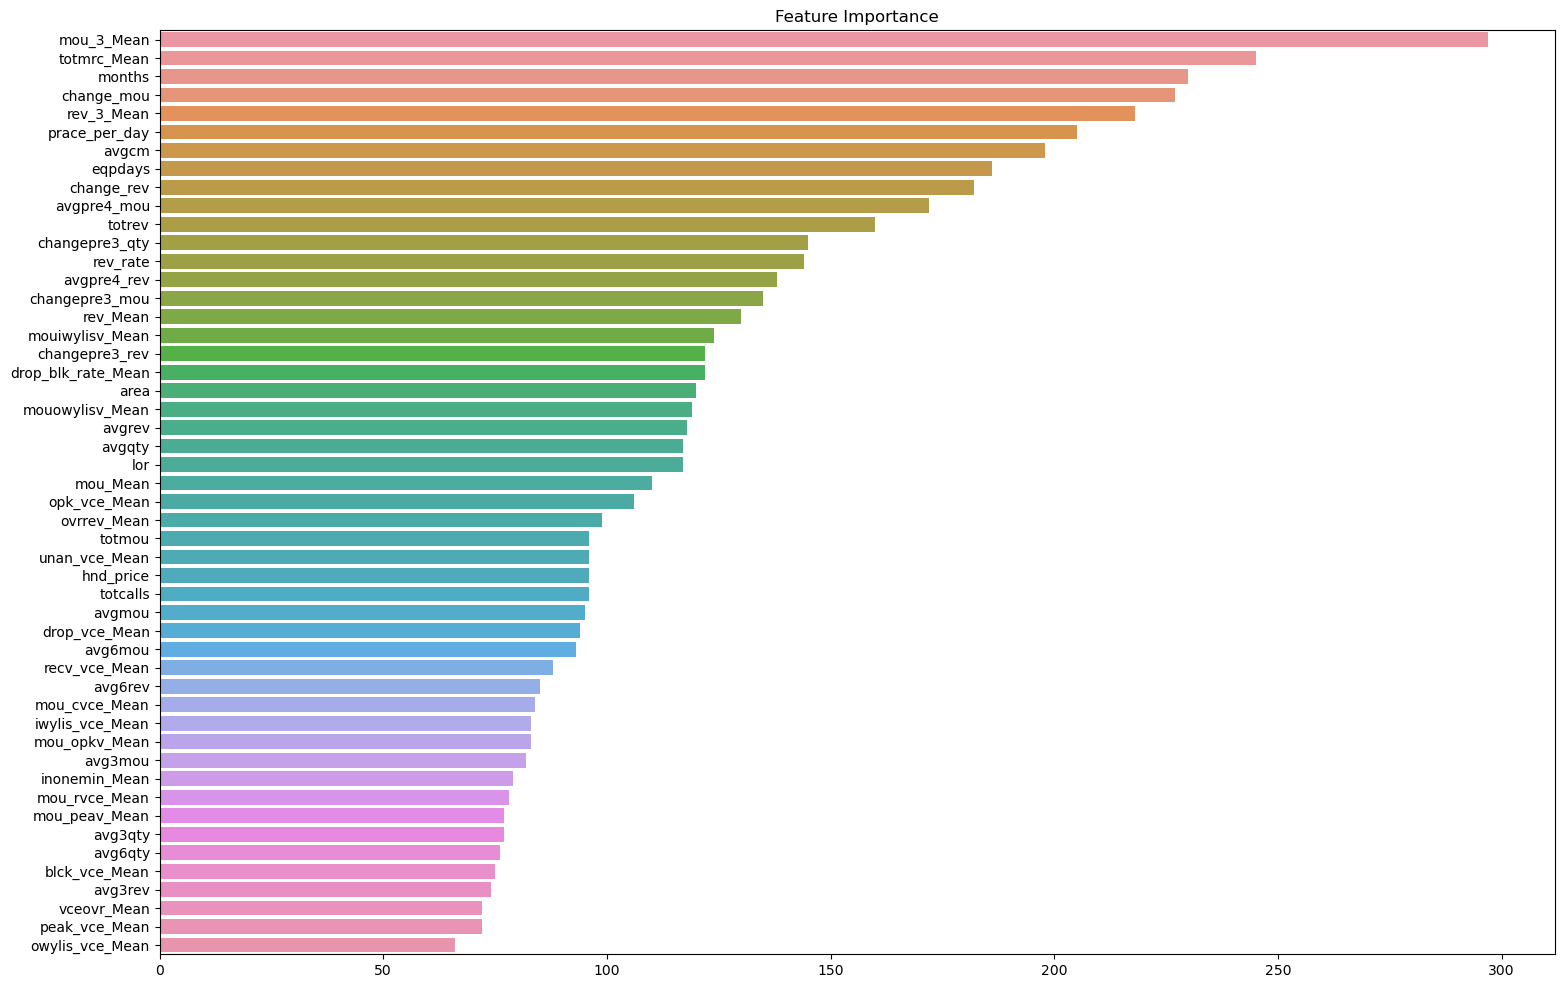

In [179]:
feature_imp = pd.Series(model.feature_importance(), index=X_std.columns).sort_values(
    ascending=False
)
plt.figure(figsize=(18, 12))
sns.barplot(x=feature_imp[:50], y=feature_imp[:50].index)
plt.title("Feature Importance")
plt.show()

In [181]:
import shap
explainer = shap.Explainer(model, X_std)
shap_values = explainer(X_std, check_additivity=False)

100%|===================| 99959/100000 [15:55<00:00]        

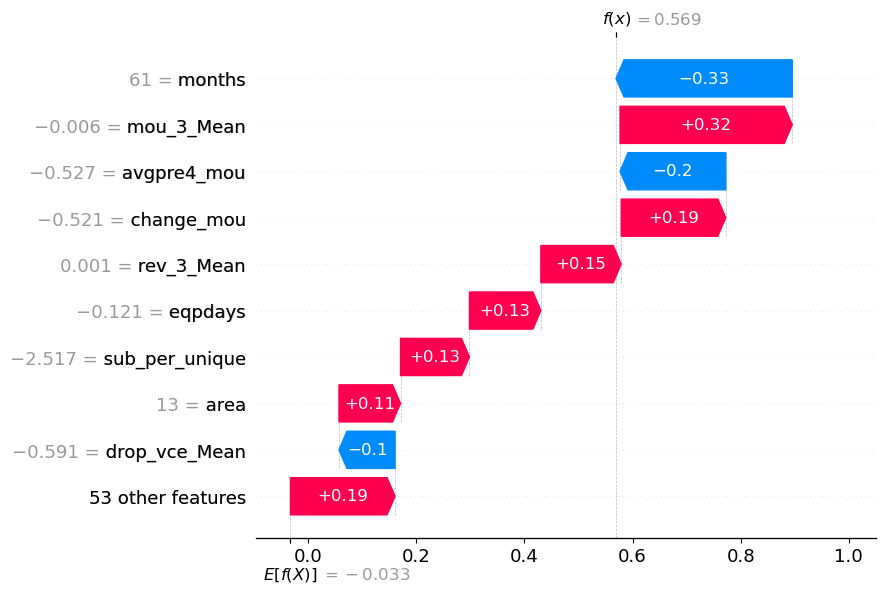

In [182]:
shap.plots.waterfall(shap_values[0])

In [15]:
shap.initjs()
shap.plots.force(shap_values[0])

In [1]:
shap.plots.scatter(shap_values[:, "RM"], color=shap_values)

NameError: name 'shap' is not defined

In [ ]:
shap.plots.beeswarm(shap_values)

In [ ]:
shap.plots.bar(shap_values)

M0=set()
M1=set()
M2={0}
M3={0}
M4=set()
M5=set()
M6=set()


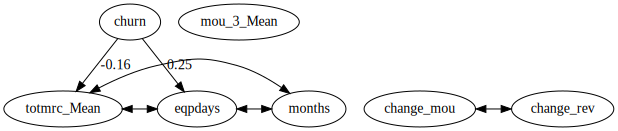

In [183]:
# LinGAM必要ライブラリのインストール
import lingam
from lingam.utils import  make_dot
# 因果探索
RCD = lingam.RCD()
list = ["churn"]
importance_index = pd.Series(model.feature_importance(), index=X_std.columns).sort_values(ascending=False).index
list =list + importance_index[:6].tolist()
x = X_std.join(y)[list].sample(5000)
RCD.fit(x)
# 　結果をリスト化
ancestors_list = RCD.ancestors_list_

for i, ancestors in enumerate(ancestors_list):
    print(f"M{i}={ancestors}")
make_dot(RCD.adjacency_matrix_, labels=x.columns.values.tolist())

In [ ]:
print(ancestors_list)

In [15]:
from pycaret.classification import setup, compare_models

exp = setup(data=df, target="churn", session_id=123, fold_shuffle=True)
compare_models()

IntProgress(value=0, description='Processing: ', max=3)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,23:20:26
Status,. . . . . . . . . . . . . . . . . .,Preprocessing Data


Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
uniqsubs,Categorical
actvsubs,Categorical
new_cell,Categorical
crclscod,Numeric
asl_flag,Categorical
...,...
change3_mou,Numeric
change3_qty,Numeric
prev4_rev,Numeric
prev4_mou,Numeric


In [ ]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
df["TARGET"].value_counts().plot.pie(
    explode=[0, 0.1], autopct="%1.1f%%", ax=ax[0], shadow=True
)
ax[0].set_title("TARGET")
ax[0].set_ylabel("")
sns.countplot("TARGET", data=df, ax=ax[1])
ax[1].set_title("TARGET")
plt.show()

In [ ]:
categ_nominal = [
    "NAME_CONTRACT_TYPE",
    "CODE_GENDER",
    "FLAG_OWN_CAR",
    "FLAG_OWN_REALTY",
    "NAME_TYPE_SUITE",
    "NAME_INCOME_TYPE",
    "NAME_EDUCATION_TYPE",
    "NAME_FAMILY_STATUS",
    "NAME_HOUSING_TYPE",
    "OCCUPATION_TYPE",
    "ORGANIZATION_TYPE",
]

In [ ]:
for i in categ_nominal:
    df = pd.concat(
        [df, pd.get_dummies(df[i], prefix=i, dummy_na=True)], sort=False, axis=1
    )
df = df.drop(categ_nominal, axis=1)
df.info()

In [ ]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [ ]:
X = df.drop("TARGET", axis=1)
y = df["TARGET"]  # 目的変数
# トレーニングデータ,テストデータの分割
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=0
)

今回は不均衡データであることから、評価指標には AUC を用いることにします。適切な評価指標を選ぶことは最終課題でも重要です。


In [ ]:
# 学習に使用するデータを設定
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

# パラメータ
params = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "binary",  # 目的 : 分類
    "metric": {"auc"},
    "num_leaves": 20,
    "max_depth": 5,
    "min_data_in_leaf": 3,
    "num_iteration": 100,
    "learning_rate": 0.03,
    "num_boost_round": 100,
    "early_stopping_rounds": 20,
}

# モデルの学習
model = lgb.train(
    params,
    train_set=lgb_train,  # トレーニングデータの指定
    valid_sets=lgb_eval,  # 検証データの指定
)

# テストデータの予測
y_pred = model.predict(X_valid)

モデルの学習が終わりました。決定木ベースのアンサンブル分析器では特徴量の重要度を算出することができるため、可視化してみます。


In [ ]:
lgb.plot_importance(model, height=0.5, figsize=(30, 40))

モデルの学習に当たって重要と判断された特徴量について可視化することができました。重要と判断された特徴量に関していくつか検討してみることにします。それぞれの特徴量に関して、平均値や中央値、データの分布を確認し、債務不履行の有無でウィルコクソンの順位和検定を有意水準を 5%として検定し、2 群の中央値に有意差があるか検討してみます。


まずは EXT_SOURCE_1 に関して検討します。


In [ ]:
df.groupby(["TARGET"])["EXT_SOURCE_1"].mean()

In [ ]:
df.groupby(["TARGET"])["EXT_SOURCE_1"].median()

実際に債務不履行の有無による EXT_SOURCE_1 の中央値やヒストグラムを可視化してみましょう。


In [ ]:
sns.barplot(x="TARGET", y="EXT_SOURCE_1", data=df, estimator=np.median)

In [ ]:
df.groupby("TARGET")["EXT_SOURCE_1"].plot.hist(bins=20, alpha=0.5, legend=True)

ウィルコクソンの順位和検定を有意水準を 5%として検定し、2 群の中央値に有意差があるか検討してみます。


In [ ]:
from scipy import stats

s, pvalue = stats.mannwhitneyu(
    df[df["TARGET"] == 1]["EXT_SOURCE_1"],
    df[df["TARGET"] == 0]["EXT_SOURCE_1"],
    alternative="two-sided",
)
pvalue < 0.05

この検定より、債務不履行の有無に関して EXT_SOURCE_1 には有意差があり、カラム名から察するに外部からの、この信用スコアのようなものが高いと債務不履行になりにくいことが分かりました。反対に、顧客データから顧客の信用スコアを求めることで他社に有益な情報を供与できるかもしれません。信用スコアを他社に提供する分、顧客に還元するアイデアなども考えられます。


次に、DAYS_BIRTH について検討します。


In [ ]:
df.groupby(["TARGET"])["DAYS_BIRTH"].mean()

In [ ]:
df.groupby(["TARGET"])["DAYS_BIRTH"].median()

In [ ]:
sns.barplot(x="TARGET", y="DAYS_BIRTH", data=df, estimator=np.median)

In [ ]:
df.groupby(["TARGET"])["DAYS_BIRTH"].plot.hist(bins=20, alpha=0.5, legend=True)

In [ ]:
s, pvalue = stats.mannwhitneyu(
    df[df["TARGET"] == 1]["DAYS_BIRTH"],
    df[df["TARGET"] == 0]["DAYS_BIRTH"],
    alternative="two-sided",
)
pvalue < 0.05

この検定より、債務不履行の有無に関して DAYS_BIRTH には有意差があることが分かりました。値を鑑みるに、年齢は数字の絶対値が小さい方が若いと考えられるので、若い人の方が債務不履行になりやすいと言え、若年層が返済しやすい融資プランの需要があることが予想できます。


次に、AMT_CREDIT(融資額)について検討します。


In [ ]:
df.groupby(["TARGET"])["AMT_CREDIT"].mean()

In [ ]:
df.groupby(["TARGET"])["AMT_CREDIT"].median()

In [ ]:
sns.barplot(x="TARGET", y="AMT_CREDIT", data=df, estimator=np.median)

In [ ]:
df.groupby(["TARGET"])["AMT_CREDIT"].plot.hist(bins=20, alpha=0.5, legend=True)

In [ ]:
s, pvalue = stats.mannwhitneyu(
    df[df["TARGET"] == 1]["AMT_CREDIT"],
    df[df["TARGET"] == 0]["AMT_CREDIT"],
    alternative="two-sided",
)
pvalue < 0.05

この検定より、債務不履行の有無に関して AMT_CREDIT には有意差があることが分かりました。値が小さい方が債務不履行になりやすいという結果なので、問題は借入金の総額ではなく、収入との問題があるのかもしれません。収入 AMT_INCOME_TOTAL に関して検討してみます。


In [ ]:
df.groupby(["TARGET"])["AMT_INCOME_TOTAL"].mean()

In [ ]:
df.groupby(["TARGET"])["AMT_INCOME_TOTAL"].median()

In [ ]:
sns.barplot(x="TARGET", y="AMT_INCOME_TOTAL", data=df, estimator=np.median)

In [ ]:
df.groupby(["TARGET"])["AMT_INCOME_TOTAL"].plot.hist(bins=20, alpha=0.5, legend=True)

In [ ]:
df.groupby(["TARGET"])["AMT_INCOME_TOTAL"].plot.hist(
    bins=20, alpha=0.5, log=True, legend=True
)
# スケールが見にくいので対数変換

In [ ]:
s, pvalue = stats.mannwhitneyu(
    df[df["TARGET"] == 1]["AMT_INCOME_TOTAL"],
    df[df["TARGET"] == 0]["AMT_INCOME_TOTAL"],
    alternative="two-sided",
)
pvalue < 0.05

この検定より、債務不履行の有無に関して AMT_INCOME_TOTAL には有意差があることが分かりました。値が小さい方が債務不履行になりやすいという結果なので、収入が少ない人の方が債務不履行になりやすいということが分かりました。ここから、収入が少ない人への適切な融資プランの需要が考えられます。


先ほど予想したように、借入金が多ければ債務不履行になりやすいという訳ではないようなので、収入と借入金の割合について考えてみたいと思います。


In [ ]:
df["Ratio_of_income_to_debt"] = df["AMT_CREDIT"] / df["AMT_INCOME_TOTAL"]
df.groupby(["TARGET"])["Ratio_of_income_to_debt"].mean()

In [ ]:
df.groupby(["TARGET"])["Ratio_of_income_to_debt"].median()

In [ ]:
sns.barplot(x="TARGET", y="Ratio_of_income_to_debt", data=df, estimator=np.median)

In [ ]:
df.groupby("TARGET")["Ratio_of_income_to_debt"].plot.hist(
    bins=20, alpha=0.5, legend=True
)

In [ ]:
s, pvalue = stats.mannwhitneyu(
    df[df["TARGET"] == 1]["Ratio_of_income_to_debt"],
    df[df["TARGET"] == 0]["Ratio_of_income_to_debt"],
    alternative="two-sided",
)
pvalue < 0.05

どうやら、債務不履行かどうかは年収と借入金の比では決定しないようです。収入が少ない人の場合、借入金の割合や額が少なくても債務不履行になるケースが多いのかもしれません。

今回は上手くいきませんでしたが、仮説を立ててデータを色々な角度から分析するのは企業の課題を見つけるのに有効な手段の一つです。


ここまでのデータ分析から、**外部の信用スコアが重要であることや、若者や収入の少ない人は債務不履行者になりやすい課題**が見えてきました。
今回は簡便な方法で EDA を行いましたが、更に深く探索を行うことや、全く別の観点から EDA を行うことは評価に繋がります。


今回は EDA の手段として LightGBM を用いましたが、この学習結果をモデル構築の一部とすることも可能です。**最終課題では、データ分析結果を可視化して提示し、どのようなことが明らかになったのか示すとともに、機械学習によるモデル構築を行いましょう。この流れに沿って行けば、どのような事業提案を行ったらよいかが見えてくると思います。**


tips:可視化を行う際に、日本語を軸の名前などに記述したい時には japanize_matplotlib を用いると便利です。調べてみてください。


最終課題の説得力を上げる一つの方法としては、事業に定量性を持たせることです。機械学習モデルを用いて、例えば今回のケースなら債務不履行者による損失がどれだけ減らせるか示すことができれば、定量性が上がり説得力が増します。

まず、機械学習する前の Home Credit 社の損失合計を求めてみます。債務不履行者の合計金額を求めればいいですから、


In [ ]:
loss_sum = df[df["TARGET"] == 1]
loss_sum["AMT_CREDIT"].sum()

これより、通貨単位をドルとして、7665723153 ドルの損失があることが分かりました。ここで、今回機械学習で債務不履行者と予測した融資金額の合計を算出します。なお、債務不履行者かどうかは、実際の債務不履行者の割合が 8%程度であることを考え、今回は大雑把ですが予測確率が上位の 5%より小さいかどうかで判定してみます。


In [ ]:
X_valid["pred"] = y_pred
X_valid["pred"].hist()

In [ ]:
threshold = X_valid["pred"].quantile(0.95)
print(threshold)
X_valid.loc[X_valid["pred"] < threshold, "pred"] = 0
X_valid.loc[X_valid["pred"] >= threshold, "pred"] = 1

In [ ]:
loss_pred = X_valid[X_valid["pred"] == 1]
loss_pred["AMT_CREDIT"].sum()

In [ ]:
787740439.5 / 0.8

債務不履行者と予測した人への融資金額は 787740439.5 ドルでした。訓練データ・テストデータの分割(8 割と 2 割)を考慮すると、これらがほぼランダムに分割できているのであれば 984675549.375 ドルの損失があると言えます。機械学習を用いて債務不履行者と判定した人に融資を行わなければ、これだけの損失を回避することができます。ただし、この計算ではモデルの性能等を全く考慮していないので、やや乱暴な理論と言えます。しかし、ただ機械学習をして債務不履行者を予測します、と事業提案されるよりは具体的で分かりやすい説明になると言えます。


本サンプルでは行っておりませんが、**市場調査を行うことも説得力の観点で大事**です。例えば同業他社ではどのような問題を抱えており、その課題をいかにデータで解決できるか示すことができれば説得力を増すことができます。


以上で最終課題のサンプルとします。

最終課題の評価を上げるには、データ分析を綿密に行うこと、モデルの性能を高めること、斬新な事業を提案すること、隙のない議論に基づいた定量性のある事業を提案することなどが考えられます。また、事業提案ですので、ビジネスモデルキャンバスやリーンキャンバスを用いることも有効だと考えられます。ぜひ調べてみてください。非常にチャレンジングな課題ですが、今まで学んだことを活かしてデータ分析や機械学習を用いた事業を提案して下さい。皆さんの力作をお待ちしております。
